<div><div style="float:left; clear:both;"><img src="img/colab.png" align="left" width="200" height="200" /><br></div><div style="float:left; clear:both;"><a href="https://colab.research.google.com/drive/11qkRR_YcEN-C8GGlfFcgFGWkdVUIPziP">Abre este Jupyter en Google Colab</a></div></div>

# Evaluación de resultados

En este notebook se muestran técnicas para la evaluación de los resultados de una predicción con un algoritmo de Machine Learning

## Conjunto de datos

### Descripción
NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

### Ficheros de datos
* <span style="color:green">**KDDTrain+.ARFF**: The full NSL-KDD train set with binary labels in ARFF format</span>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF:	A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT:	A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF:	The full NSL-KDD test set with binary labels in ARFF format
* KDDTest+.TXT:	The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF:	A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT:	A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

### Descarga de los ficheros de datos
https://iscxdownloads.cs.unb.ca/iscxdownloads/NSL-KDD/#NSL-KDD

### Referencias adicionales sobre el conjunto de datos
_M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009._

## Imports

In [183]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

In [184]:
def cargar_arff_a_dataframe(data_path):
    """
    Carga un conjunto de datos ARFF en un DataFrame de pandas.

    Parámetros:
        data_path (str): Ruta al archivo ARFF.

    Retorna:
        pandas.DataFrame: DataFrame con los datos del archivo ARFF.

    Lanza:
        FileNotFoundError: Si no existe el archivo en data_path.
        ValueError: Si el archivo ARFF es inválido o faltan datos requeridos.
    """
    try:
        with open(data_path, 'r') as f:
            dataset = arff.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"No se encontró el archivo {data_path}.")
    except arff.ArffException as e:
        raise ValueError(f"Formato ARFF inválido: {e}")
    except Exception as e:
        raise RuntimeError(f"Error al procesar el archivo: {e}")

    # Extraer nombres de columnas
    atributos = dataset.get('attributes', [])
    if not atributos:
        raise ValueError("El archivo ARFF no contiene atributos.")
    nombres_columnas = [atrib[0] for atrib in atributos]

    # Extraer datos
    datos = dataset.get('data', [])
    if not datos:
        raise ValueError("El archivo ARFF no contiene datos.")

    # Crear DataFrame
    df = pd.DataFrame(datos, columns=nombres_columnas)

    return df

In [185]:
def train_val_test_split(X, y, test_size, val_size, random_state=None, stratify=None):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba de forma reproducible.
    
    Args:
        X (pd.DataFrame): Características
        y (pd.Series): Variable objetivo
        test_size (float): Proporción para prueba (entre 0 y 1)
        val_size (float): Proporción para validación (entre 0 y 1)
        random_state (int): Semilla para reproducibilidad
        stratify (pd.Series): Variable para estratificación
        
    Returns:
        Tupla con (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # Calcular tamaño total para validación + prueba
    total_test_val = test_size + val_size
    
    # Primera división: entrenamiento vs (validación + prueba)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=total_test_val,
        random_state=random_state,
        stratify=stratify
    )
    
    # Calcular proporción para prueba dentro del conjunto temporal
    test_ratio = test_size / total_test_val
    
    # Segunda división: validación vs prueba
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=test_ratio,
        random_state=random_state,
        stratify=(y_temp if stratify is not None else None)  # Aquí estaba el error
    )  # Se agregó el paréntesis de cierre faltante
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [186]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class DataFrameOneHotEncoder(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado para codificación One-Hot de columnas categóricas en DataFrames de pandas.
    Mantiene columnas numéricas sin cambios y combina resultados en un nuevo DataFrame.
    """
    
    def __init__(self):
        # Configurar el codificador One-Hot con parámetros requeridos
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        # Almacenar nombres de columnas categóricas detectadas
        self.cat_columns_ = None  
        # Almacenar nombres de las nuevas características codificadas
        self.encoded_features_ = None  

    def fit(self, X, y=None):
        """
        Identifica columnas categóricas (tipo object) y ajusta el codificador.
        
        Parámetros:
        X : DataFrame de pandas - Datos de entrada
        y : ignorado (por compatibilidad)
        """
        # 1. Identificar columnas categóricas
        self.cat_columns_ = X.select_dtypes(include=['object']).columns.tolist()
        
        # 2. Si hay columnas categóricas, entrenar el codificador
        if self.cat_columns_:
            self.encoder.fit(X[self.cat_columns_])
            # Obtener nombres legibles de características codificadas (ej: 'col_gato')
            self.encoded_features_ = self.encoder.get_feature_names_out(self.cat_columns_)
        else:
            self.encoded_features_ = []  # Caso sin columnas categóricas
            
        return self  # Por convención en scikit-learn

    def transform(self, X):
        """
        Aplica la transformación y devuelve un DataFrame con columnas numéricas + codificadas.
        
        Parámetros:
        X : DataFrame de pandas - Datos a transformar
        """
        # 1. Conservar columnas numéricas originales
        X_num = X.drop(columns=self.cat_columns_)
        
        # 2. Inicializar DataFrame para características codificadas (mantiene índices)
        encoded_cat_df = pd.DataFrame(index=X.index)
        
        # 3. Si hay columnas categóricas, aplicar codificación
        if self.cat_columns_:
            X_cat = X[self.cat_columns_]
            encoded_cat = self.encoder.transform(X_cat)  # Aplicar one-hot
            
            # Convertir a DataFrame con nombres de columnas y mantener índices
            encoded_cat_df = pd.DataFrame(
                encoded_cat,
                columns=self.encoded_features_,
                index=X.index
            )
        
        # 4. Combinar características numéricas y codificadas
        combined_df = pd.concat([X_num, encoded_cat_df], axis=1)
        
        return combined_df

In [187]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocesador de datos automático para características numéricas y categóricas.
    Mantiene nombres de columnas y compatibilidad con scikit-learn.
    
    Características:
    - Imputación y escalado para características numéricas
    - Codificación one-hot con nombres de columnas legibles
    - Manejo automático de tipos de datos
    - Preserva índices de DataFrames
    - Manejo de categorías no vistas y valores faltantes
    """
    
    def __init__(self):
        self.numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        
        self.categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        self.feature_names_ = None
        self.numeric_columns_ = None
        self.categorical_columns_ = None
    
    def _detect_features(self, X):
        """Detecta automáticamente columnas numéricas y categóricas"""
        self.numeric_columns_ = X.select_dtypes(include=np.number).columns.tolist()
        categorical_dtypes = ['object', 'category', 'bool']
        self.categorical_columns_ = X.select_dtypes(include=categorical_dtypes).columns.tolist()
    
    def _get_feature_names(self, ct_features):
        """Obtiene nombres de columnas limpios del ColumnTransformer"""
        clean_features = []
        for feat in ct_features:
            if '__' in feat:
                # Remover prefijos del pipeline
                clean_feat = feat.split('__')[-1]
            else:
                clean_feat = feat
            # Manejar nombres de categorías codificadas
            clean_feat = clean_feat.replace('_x0_', '_')
            clean_features.append(clean_feat)
        return clean_features
    
    def fit(self, X, y=None):
        """Aprende estructura de datos y nombres de columnas"""
        self._detect_features(X)
        
        # Crear y ajustar ColumnTransformer
        self.ct_ = ColumnTransformer([
            ('num', self.numeric_pipeline, self.numeric_columns_),
            ('cat', self.categorical_pipeline, self.categorical_columns_)
        ], remainder='drop')
        
        self.ct_.fit(X)
        
        # Obtener y almacenar nombres de columnas
        ct_features = self.ct_.get_feature_names_out()
        self.feature_names_ = self._get_feature_names(ct_features)
        
        return self
    
    def transform(self, X):
        """Aplica transformaciones y devuelve DataFrame con nombres de columnas"""
        # Aplicar transformaciones
        X_tr = self.ct_.transform(X)
        
        # Crear DataFrame manteniendo el índice original
        X_df = pd.DataFrame(
            X_tr,
            columns=self.feature_names_,
            index=X.index
        )
        
        return X_df

## Lectura del conjunto de datos

In [188]:
df = cargar_arff_a_dataframe("Marketing.arff")

In [189]:
df.head(10)

,customerid,age,gender,location,emailopened,emailclicked,productpagevisit,discountoffered,purchased
0,1.0,22.0,0.0,Perth,1.0,1.0,3.0,1.0,1.0
1,2.0,55.0,0.0,Auckland,1.0,0.0,0.0,0.0,0.0
2,3.0,15.0,1.0,Sydney,0.0,1.0,2.0,1.0,1.0
3,4.0,25.0,0.0,Brisbane,1.0,1.0,5.0,1.0,0.0
4,5.0,36.0,1.0,Brisbane,0.0,1.0,1.0,1.0,0.0
5,6.0,30.0,0.0,Sydney,0.0,0.0,0.0,0.0,0.0
6,7.0,28.0,1.0,Sydney,0.0,0.0,3.0,1.0,1.0
7,8.0,19.0,1.0,Sydney,1.0,1.0,2.0,0.0,0.0
8,9.0,59.0,0.0,Perth,1.0,1.0,1.0,0.0,0.0
9,10.0,45.0,1.0,Auckland,0.0,0.0,0.0,0.0,0.0


## División del conjunto de datos

In [190]:
# Separar características y variable objetivo
X = df.drop("purchased", axis=1)  # Características
y = df["purchased"]               # Etiqueta objetivo


In [191]:
# Dividir los datos (70% entrenamiento, 15% validación, 15% prueba)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y,
    test_size=0.15,
    val_size=0.15,
    random_state=42,
    stratify=y
)


In [192]:
# Función para imprimir estadísticas
def print_stats(name, dataset, labels):
    print(f"\n{name}:")
    print(f"- Cantidad de muestras: {len(dataset)}")
    print("- Distribución de clases:")
    print(labels.value_counts().to_string())

In [193]:
# Imprimir estadísticas de cada conjunto
print_stats("Conjunto de Entrenamiento", X_train, y_train)
print_stats("Conjunto de Validación", X_val, y_val)
print_stats("Conjunto de Prueba", X_test, y_test)


Conjunto de Entrenamiento:
- Cantidad de muestras: 28000
- Distribución de clases:
purchased
0.0    14001
1.0    13999

Conjunto de Validación:
- Cantidad de muestras: 6000
- Distribución de clases:
purchased
0.0    3000
1.0    3000

Conjunto de Prueba:
- Cantidad de muestras: 6000
- Distribución de clases:
purchased
0.0    3001
1.0    2999


## Preparación del conjunto de datos

In [194]:
data_preparer = DataPreprocessor()

In [195]:

X_train_prep = data_preparer.fit_transform(X_train)

In [196]:
X_train.head(5)

,customerid,age,gender,location,emailopened,emailclicked,productpagevisit,discountoffered
3092,3093.0,15.0,1.0,Brisbane,1.0,1.0,4.0,0.0
20860,20861.0,24.0,1.0,Sydney,1.0,0.0,1.0,0.0
1619,1620.0,52.0,1.0,Perth,1.0,0.0,3.0,1.0
22630,22631.0,42.0,0.0,Sydney,1.0,0.0,6.0,0.0
21670,21671.0,66.0,0.0,Auckland,0.0,0.0,4.0,1.0


In [197]:
X_train_prep.head(5)

,customerid,age,gender,emailopened,emailclicked,productpagevisit,discountoffered,location_Auckland,location_Brisbane,location_Melbourne,location_Perth,location_Sydney
3092,-1.457676,-1.713366,0.994444,0.995226,0.9995,-0.162654,-1.004941,0.0,1.0,0.0,0.0,0.0
20860,0.081504,-1.145029,0.994444,0.995226,-1.0005,-1.206985,-1.004941,0.0,0.0,0.0,0.0,1.0
1619,-1.585277,0.623132,0.994444,0.995226,-1.0005,-0.510765,0.995084,0.0,0.0,0.0,1.0,0.0
22630,0.234833,-0.008354,-1.005587,0.995226,-1.0005,0.533566,-1.004941,0.0,0.0,0.0,0.0,1.0
21670,0.151671,1.507213,-1.005587,-1.004797,-1.0005,-0.162654,0.995084,1.0,0.0,0.0,0.0,0.0


In [198]:
X_val_prep = data_preparer.fit_transform(X_val)

In [199]:
X_val.head(5)

,customerid,age,gender,location,emailopened,emailclicked,productpagevisit,discountoffered
2266,2267.0,26.0,0.0,Melbourne,1.0,1.0,7.0,0.0
1697,1698.0,57.0,1.0,Perth,0.0,1.0,5.0,0.0
14928,14929.0,34.0,1.0,Sydney,1.0,1.0,2.0,1.0
18710,18711.0,62.0,0.0,Sydney,1.0,0.0,2.0,1.0
22849,22850.0,48.0,1.0,Sydney,0.0,1.0,5.0,1.0


In [200]:
X_val_prep.head(5)

,customerid,age,gender,emailopened,emailclicked,productpagevisit,discountoffered,location_Auckland,location_Brisbane,location_Melbourne,location_Perth,location_Sydney
2266,-1.546545,-0.993398,-0.999000,1.008368,0.995676,0.878636,-1.006689,0.0,0.0,1.0,0.0,0.0
1697,-1.595873,0.959031,1.001001,-0.991701,0.995676,0.183971,-1.006689,0.0,0.0,0.0,1.0,0.0
14928,-0.448833,-0.489545,1.001001,1.008368,0.995676,-0.858028,0.993355,0.0,0.0,0.0,0.0,1.0
18710,-0.120959,1.273938,-0.999000,1.008368,-1.004343,-0.858028,0.993355,0.0,0.0,0.0,0.0,1.0
22849,0.237865,0.392197,1.001001,-0.991701,0.995676,0.183971,0.993355,0.0,0.0,0.0,0.0,1.0


## Entrenamiento de un algoritmo de Regresión Logística

La instanciación de un algoritmo de Machine Learning utilizando Sklearn se realiza utilizando los métodos expuestos por la API de sklearn tal y como se ha presentado en cuadernos anteriores.

In [201]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

## Predicción de nuevos ejemplos

Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Utilizamos el subconjunto de validación.

In [202]:
y_pred = clf.predict(X_val_prep)

## 1. Matriz de Confusión

In [203]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[1536, 1464],
       [1560, 1440]])

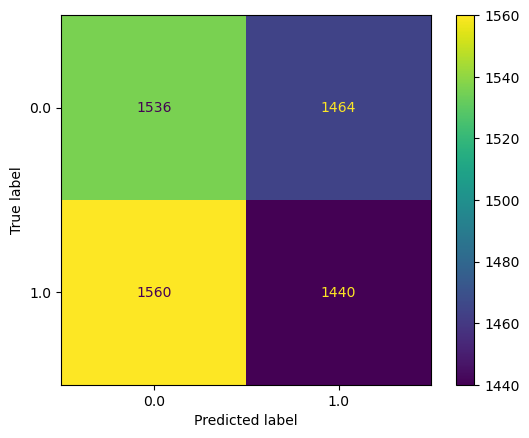

In [204]:

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_val_prep, y_val, values_format='d')

## 2. Métricas derivadas de la matriz de confusión

### Precisión

In [205]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_val, y_pred, pos_label=1))

Precisión: 0.49586776859504134


### Recall

In [206]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(y_val, y_pred, pos_label=1))

Recall: 0.48


### F1 Score

In [207]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label=1))

F1 score: 0.4878048780487805


## 3. Curvas ROC y PR

### Curva ROC

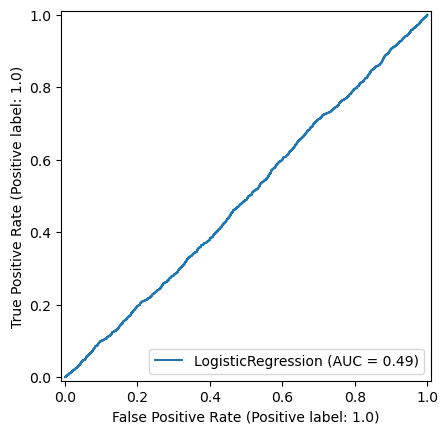

In [208]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

### Curva PR

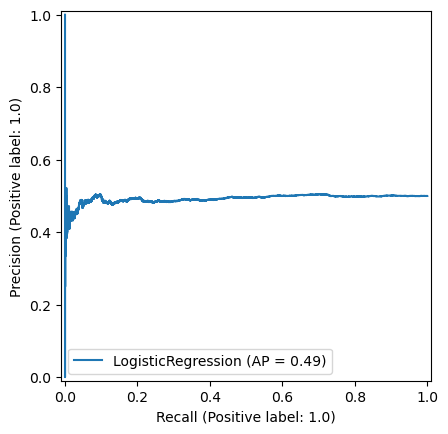

In [209]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val)

## 4. Evaluación del modelo con el conjunto de datos de pruebas

In [210]:
X_test_prep = data_preparer.transform(X_test)

In [212]:

y_pred = clf.predict(X_test_prep)

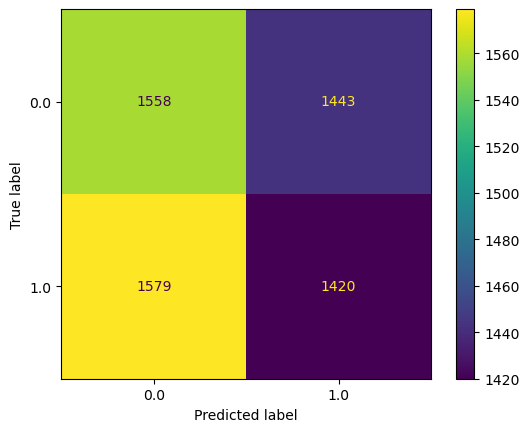

In [181]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_prep, y_test, values_format='d')

In [213]:
print("F1 score:", f1_score(y_test, y_pred, pos_label=1))

F1 score: 0.4844762879563289
